<a href="https://colab.research.google.com/github/promedius/tutorial/blob/master/KOHI_Hands_On_DCGAN_tutorial_20200825.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KOHI 의료 인공지능 전문가 양성과정: DCGAN으로 손글씨(숫자) 생성하기

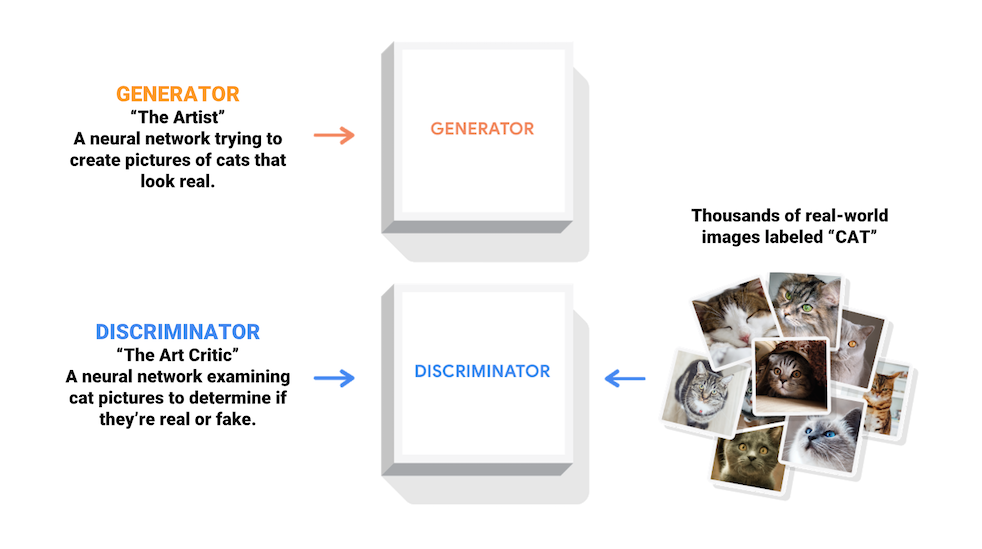


**DCGAN 구조**

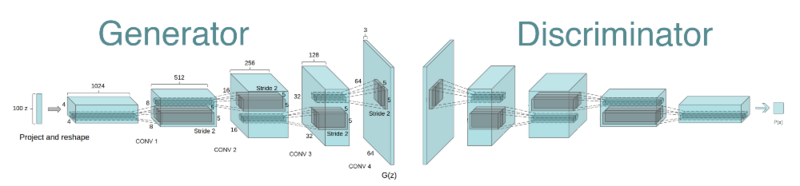

본 튜토리얼은 DCGAN (Deep Convolutional Generative Adversarial Networkds, DCGAN)을 이용하여 손으로 쓴 글자들을 어떻게 생성할 수 있는지 보여줍니다. 이 코드는 케라스 Sequential API 와 tf.GradientTape 훈련루프를 사용하여 작성되었습니다. 

In [2]:
#https://www.tensorflow.org/tutorials/generative/dcgan?hl=en
#Licensed under the Apache License, Version 2.0 (the "License");
#참고: https://m.blog.naver.com/laonple/221201915691

# 1. 라이브러리 준비

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.0.0'

In [ ]:
# GIF를 만들기위해 설치합니다.
!pip install imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# 2. MNIST 데이터셋 준비

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512

In [ ]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3. 모델 만들기

In [ ]:
# 생성자(Generator) 모델 만들기
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 입력받은 랜덤시드로 upsample
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None 값은 나중에 batch size가 됩니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, ??, ??, ??) # ??에는 어떤 숫자가 들어가야 할까요?
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1) # MNIST 데이터셋 크기에 맞는 output

    return model

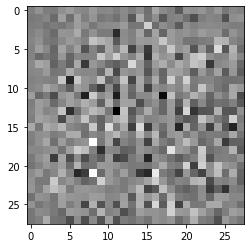

In [ ]:
generator = make_generator_model() #생성자 모델을 정의

noise = tf.random.normal([1, 100]) #랜덤 노이즈 생성
generated_image = generator(noise, training=False) #노이즈를 통해 이미지 생성

plt.imshow(generated_image[0, :, :, 0], cmap='gray') #생성된 이미지 확인 (학습 전)

In [ ]:
# 감별자(Discriminator) 모델 만들기
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[??, ??, ??]))  # ??에는 어떤 숫자가 들어가야 할까요?
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model #CNN 기반의 이미지 분류 모델 : 생성자가 생성한 이미지를 진짜인지 가짜인지 판별

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00092934]], shape=(1, 1), dtype=float32)


# 4. 손실함수와 옵티마이저 정의

In [ ]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# 감별자 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 진짜이미지를 얼마나 잘 '진짜'라고 판별했는지
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 가짜이미지를 얼마나 잘 '가짜'라고 판별했는지
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# 생성자 손실함수 - 얼마나 감별자를 잘 속였는가
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 감별자가 가짜라고 판별한 이미지가 실제론 진짜 이미지 였다면 잘 속인 것

In [ ]:
# 두개의 모델, 두개의 옵티마이저
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 5. 체크포인트 저장 : 훈련이 중단될 때를 대비

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 6. 훈련 루프 정의

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# @tf.function        ==>   train_step = tf.function(train_step)
# def train_step(): 
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [1]:
# 이미지 생성 및 저장

def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰진 것을 주목하세요.
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# 7. 훈련

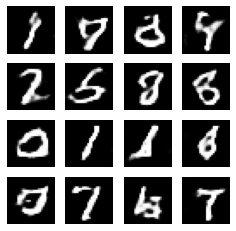

CPU times: user 1min 12s, sys: 22.5 s, total: 1min 34s
Wall time: 8min 34s


In [ ]:
# GAN을 학습시키는 것은 까다로울 수 있습니다. 생성자와 판별자 어느 한쪽이 너무 압도하지 않도록 해야합니다.
# 학습 초기에는 생성된 이미지가 노이즈처럼 보일 것입니다. 그러나 시간이 지나면 점점 학습에 사용했던 MNIST데이터들과 비슷하게 변할 것입니다.
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 8. 결과 : GIF파일 생성

In [ ]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

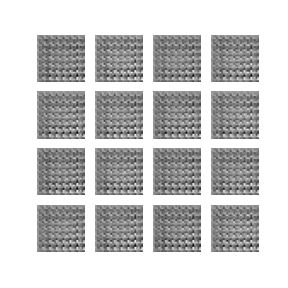

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
# Colab 환경에서는 아래 코드를 이용해 애니메이션을 다운로드 받을 수 있습니다
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>